In [72]:
from collections import defaultdict
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import imblearn
import sklearn.metrics as metrics
import xgboost

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, chi2, RFE, RFECV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix, f1_score, recall_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import fbeta_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#Setting up graph standards
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

* [Data Loading](#data_load)
* [Baseline Evaluation: Logistic Regression](#base)
* [Modelling](#mod)
    * [Logistic Regression](#log)
    * [Random Forest](#rf)
    * [Gradient Boosting](#gbm)
* [Fine Tuning](#fine)
* [Decision Threshold](#desc)
* [Classification Report and Confusion Matrix](#class)

## Creating Different Feature Sets <a class="anchor" id="data_load"></a>

#### Original Dataset

In [3]:
X = pd.DataFrame(load_breast_cancer().data)
X.columns = load_breast_cancer().feature_names
y = pd.DataFrame(load_breast_cancer().target)

In [4]:
#Splitting test/train 50/50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (284, 30), (284, 1)
Test Data: (285, 30), (285, 1)


In [5]:
#Upsampling training data
counter = Counter(y_train)
upsample = SMOTE()
X_train, y_train = upsample.fit_resample(X_train, y_train)

print(f"Total Data after Upsampling: {len(X_train)}")
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

#Scaling train and test data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Scaled Train Data: {X_train.shape}, {y_train.shape}")
print(f"Scaled Test Data: {X_test.shape}, {y_test.shape}")

Total Data after Upsampling: 340
Train Data: (340, 30), (340, 1)
Test Data: (285, 30), (285, 1)
Scaled Train Data: (340, 30), (340, 1)
Scaled Test Data: (285, 30), (285, 1)


#### SelectKBest Feature Set<a class="anchor" id="selectkbest"></a>

In [6]:
selector = SelectKBest(f_classif, k=15) #chi2 requires non negative
feature_set_skb = selector.fit_transform(X_train,y_train)

In [7]:
X_test_skb = selector.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"SelectKBest Test Data: {X_test_skb.shape}")

Baseline Test Data: (285, 30)
SelectKBest Test Data: (285, 15)


#### Feature ranking with recursive feature elimination and cross-validated selection Feature Set <a class="anchor" id="rfecv"></a>

In [8]:
clf = LogisticRegression(random_state=42)
rfecv_clf_selector = RFECV(estimator=clf ,step=1, cv=5)
rfecv_clf_feature_set = rfecv_clf_selector.fit_transform(X_train,y_train)

In [9]:
X_test_rfecv = rfecv_clf_selector.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"RFECV Test Data: {X_test_rfecv.shape}")

Baseline Test Data: (285, 30)
RFECV Test Data: (285, 20)


#### Lasso Feature Set <a class="anchor" id="Lasso"></a>

In [10]:
# SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
estimator = LassoCV(cv=5)
sfm = SelectFromModel(estimator)
sfm_feature_set = sfm.fit_transform(X_train, y_train)

In [11]:
X_test_lasso = sfm.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"Lasso Test Data: {X_test_lasso.shape}")

Baseline Test Data: (285, 30)
Lasso Test Data: (285, 17)


#### Random Forest Feature Importance Feature Set <a class="anchor" id="rffi"></a>

In [12]:
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

In [13]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_rfi = X_train[:, selected_features]
X_test_rfi = X_test[:, selected_features]

print(f"Baseline Test Data: {X_test.shape}")
print(f"RFI Test Data: {X_test_rfi.shape}")

Baseline Test Data: (285, 30)
RFI Test Data: (285, 14)


#### Mean Feature Set

In [14]:
X_train_mean = pd.DataFrame(X_train, columns = X.columns)
X_test_mean = pd.DataFrame(X_test, columns = X.columns)

In [15]:
X_train_mean.shape
X_test_mean.shape

(285, 30)

In [16]:
#X_mean = pd.DataFrame(load_breast_cancer().data)
#X_mean.columns = load_breast_cancer().feature_names
#X_mean.columns

X_train_mean.drop(columns=['radius error', 'texture error','perimeter error','area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], inplace=True)

X_train_mean.shape

(340, 10)

In [17]:
X_test_mean.drop(columns=['radius error', 'texture error','perimeter error','area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], inplace=True)

X_test_mean.shape

(285, 10)

#### Less Correlated Feature Set

In [18]:
X_train_clean = pd.DataFrame(X_train, columns = X.columns)
X_test_clean = pd.DataFrame(X_test, columns = X.columns)

In [19]:
X_train_clean.shape
X_test_clean.shape

(285, 30)

In [20]:
X_train_clean.drop(columns=['worst smoothness', 'worst perimeter', 'mean area', 'mean concavity', 'worst concave points', 'area error', 'worst area', 'worst radius', 'worst texture', 'worst compactness', 'mean perimeter', 'worst concavity', 'perimeter error', 'mean concave points'], inplace=True)

X_train_clean.shape

(340, 16)

In [21]:
#X_clean = pd.DataFrame(load_breast_cancer().data)
#X_clean.columns = load_breast_cancer().feature_names
#X_clean.shape

X_test_clean.drop(columns=['worst smoothness', 'worst perimeter', 'mean area', 'mean concavity', 'worst concave points', 'area error', 'worst area', 'worst radius', 'worst texture', 'worst compactness', 'mean perimeter', 'worst concavity', 'perimeter error', 'mean concave points'], inplace=True)

X_test_clean.shape

(285, 16)

### Baseline Logistic Regression Model <a class="anchor" id="base"></a>

##### Original Feature Set

In [22]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
base_dict = {}

# Accuray On Test Data
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
base_dict.update({"Baseline":roc_auc*100})

y_score =clf.predict_proba(X_test)[:, 1]
orig_score = metrics.roc_auc_score(y_test, y_score)

orig_score

ROC AUC:99.71625013641821%


0.997162501364182

#### Select K Best Feature set

In [24]:
clf = LogisticRegression(random_state=42)
clf.fit(feature_set_skb, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test_skb, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_skb)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"SKB_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_skb, y_test)}"]})
base_dict.update({"Select K Best":roc_auc*100})

y_score =clf.predict_proba(X_test_skb)[:, 1]
skb_score = metrics.roc_auc_score(y_test, y_score)

skb_score

ROC AUC:99.06144275892174%


0.9906144275892175

#### RFECV Feature Set

In [25]:
clf = LogisticRegression(random_state=42)
clf.fit(rfecv_clf_feature_set, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test_rfecv, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfecv)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"RFECV_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfecv, y_test)}"]})
base_dict.update({"RFECV":roc_auc*100})

y_score =clf.predict_proba(X_test_rfecv)[:, 1]
rfecv_score = metrics.roc_auc_score(y_test, y_score)

rfecv_score



ROC AUC:99.73807704900142%


0.9973807704900142

#### Lasso Feature Set

ROC AUC:99.60711557350213%
0.9960711557350213


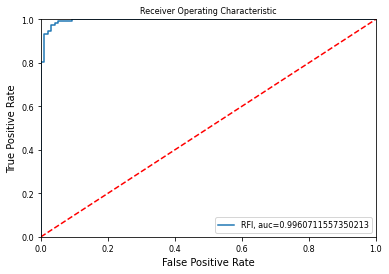

In [26]:
clf = LogisticRegression(random_state=42)
clf.fit(sfm_feature_set, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test_lasso, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_lasso)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"LassoCV_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_lasso, y_test)}"]})
base_dict.update({"Lasso CV":roc_auc*100})

y_score =clf.predict_proba(X_test_lasso)[:, 1]
lasso_score = metrics.roc_auc_score(y_test, y_score)

print(lasso_score)

plt.figure(0).clf()
plt.plot(fpr,tpr,label="RFI, auc="+str(lasso_score))

# plotting with matplotlib
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('AUC_updated.png')
plt.show()

#### Random Forest Feature Importance Feature Set

ROC AUC:99.75444723343882%
0.9975444723343883


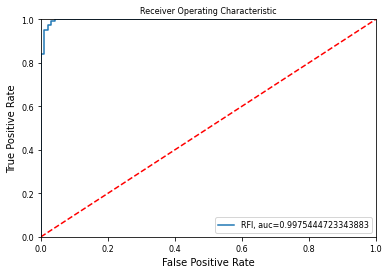

In [27]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_rfi, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test_rfi, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfi)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"RF_Feat_Importance_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfi, y_test)}"]})
base_dict.update({"RFFI":roc_auc*100})

y_score =clf.predict_proba(X_test_rfi)[:, 1]
rfi_score = metrics.roc_auc_score(y_test, y_score)

print(rfi_score)
plt.figure(0).clf()
plt.plot(fpr,tpr,label="RFI, auc="+str(rfi_score))

# plotting with matplotlib
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('AUC_updated.png')
plt.show()

#### Mean Feature Set

In [28]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_mean, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
#fs_dict = {}

# Accuray On Test Data
probs = clf.predict_proba(X_test_mean)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"Baseline_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test, y_test)}"]})
base_dict.update({"Mean Features":roc_auc*100})

y_score =clf.predict_proba(X_test_mean)[:, 1]
mean_score = metrics.roc_auc_score(y_test, y_score)

mean_score

ROC AUC:98.93593801156827%


0.9893593801156827

#### Less correlated Feature Set

In [29]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_clean, y_train)
#print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
#fs_dict = {}

# Accuray On Test Data
probs = clf.predict_proba(X_test_clean)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(f"ROC AUC:{roc_auc*100}%")
#fs_dict.update({"Baseline_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test, y_test)}"]})
base_dict.update({"Less Correlated":roc_auc*100})

y_score =clf.predict_proba(X_test_clean)[:, 1]
clean_score = metrics.roc_auc_score(y_test, y_score)

clean_score

ROC AUC:98.95776492415148%


0.9895776492415148

In [36]:
baseline_data = pd.DataFrame.from_dict(base_dict, orient='index')
baseline_data.sort_values(by=0, ascending=False)

,0
RFFI,99.754447
RFECV,99.738077
Baseline,99.716250
Lasso CV,99.607116
Select K Best,99.061443
Less Correlated,98.957765
Mean Features,98.935938


The Random Forest Feature Importance is the best data set. 

### Log Reg Grid Search with RFI Feature Set <a class="anchor" id="log"></a>

In [40]:
parameters = {
    'penalty': ['l1', 'l2', 'none'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': np.arange(100, 200, 10),
    'C':np.arange(0, 1.5, 0.2)}
grid_cv = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = parameters, cv = 5)
grid_cv.fit(X_trainrfi, y_train)
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.9676470588235295
{'C': 1.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [41]:
print(classification_report(y_test, grid_cv.best_estimator_.predict(X_test_rfi)))
grid_cv.best_estimator_.score(X_test_rfi, y_test)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        98
           1       0.99      0.96      0.98       187

    accuracy                           0.97       285
   macro avg       0.96      0.97      0.97       285
weighted avg       0.97      0.97      0.97       285



0.968421052631579

In [43]:
# Setting the model to the best combination of parameters
mod = grid_cv.best_estimator_

# Train the model using the training sets 
mod.fit(X_train_rfi,y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [56]:
y_score_log =grid_cv.best_estimator_.predict_proba(X_test_rfi)[:,1]
metrics.roc_auc_score(y_test, y_score_log)

0.9969442322383499

### Random Forest Model <a class="anchor" id="rf"></a>

In [44]:
## RF Feature importanct 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rfi, y_train)

probs = rf.predict_proba(X_test_rfi)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('RF Feature Importance Feature Set')
print({roc_auc*100})

RF Feature Importance Feature Set
{99.20604605478556}


In [45]:
parameters_rf = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }
grid_cv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), param_grid = parameters_rf, cv = 5)
grid_cv_rf.fit(X_train_rfi, y_train)
print(grid_cv_rf.best_score_)
print(grid_cv_rf.best_params_)

0.9470588235294117
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}


In [46]:
print(classification_report(y_test, grid_cv.best_estimator_.predict(X_test_rfi)))
grid_cv_rf.best_estimator_.score(X_test_rfi, y_test)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        98
           1       0.99      0.96      0.98       187

    accuracy                           0.97       285
   macro avg       0.96      0.97      0.97       285
weighted avg       0.97      0.97      0.97       285



0.9403508771929825

In [55]:
y_score_rf =grid_cv_rf.best_estimator_.predict_proba(X_test_rfi)[:,1]
metrics.roc_auc_score(y_test, y_score_rf)

0.9906417112299466

### Gradient Boosting Model  <a class="anchor" id="gbm"></a>

In [47]:
## RF Feature importanct 
gbm = GradientBoostingClassifier(random_state=42) 
gbm.fit(X_train_rfi, y_train)

probs = gbm.predict_proba(X_test_rfi)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('RF Feature Importance Feature Set')
print(f"ROC AUC:{roc_auc*100}%")

RF Feature Importance Feature Set
ROC AUC:98.87591400196442%


In [48]:
n_estimators = np.arange(100,600,100)
max_depth = [1,2,4,8]
learning_rate = [.05,.1,.2,.5,1]

param_dist = {'n_estimators': n_estimators, 'max_depth':max_depth, 'learning_rate':learning_rate}

grid_cv_gbm = GridSearchCV(estimator =GradientBoostingClassifier(random_state=42) , param_grid = param_dist, cv = 5)
grid_cv_gbm.fit(X_train_rfi, y_train)
print(grid_cv_gbm.best_score_)
print(grid_cv_gbm.best_params_)

0.9529411764705882
{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 500}


In [49]:
print(classification_report(y_test, grid_cv_gbm.best_estimator_.predict(X_test_rfi)))
grid_cv_gbm.best_estimator_.score(X_test_rfi, y_test)


              precision    recall  f1-score   support

           0       0.92      0.92      0.92        98
           1       0.96      0.96      0.96       187

    accuracy                           0.94       285
   macro avg       0.94      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285



0.9438596491228071

In [50]:
y_score =grid_cv_gbm.best_estimator_.predict_proba(X_test_rfi)[:,1]


In [51]:
metrics.roc_auc_score(y_test, y_score)

0.9915420713740042

#### Testing selected data set 

In [105]:
model_params = {
    'random_forest': {'model': RandomForestClassifier(random_state=42),
                      'params' : {
              'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]}},
    'logistic_regression' : {'model': LogisticRegression(random_state=42),
                            'params': {
                                'penalty': ['l1', 'l2', 'none'],
                                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                'max_iter': np.arange(100, 200, 10),
                                'C':np.arange(0, 1.5, 0.2)}},
    'gradient_boosting' : {'model': GradientBoostingClassifier(random_state=42),
                       'params': {
                           'n_estimators': np.arange(100,600,100), 
                           'max_depth':[1,2,4,8], 
                           'learning_rate':[.05,.1,.2,.5,1]}}
}


In [106]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_rfi,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_model = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model.to_csv('models.csv')

In [108]:
print(classification_report(y_test, clf.best_estimator_.predict(X_test_rfi)))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92        98
           1       0.96      0.96      0.96       187

    accuracy                           0.94       285
   macro avg       0.94      0.94      0.94       285
weighted avg       0.94      0.94      0.94       285



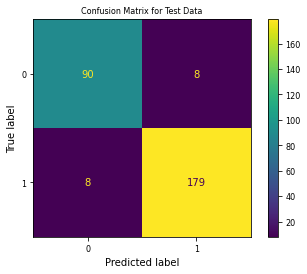

In [110]:

plot_confusion_matrix(clf,X_test_rfi, y_test)
plt.title("Confusion Matrix for Test Data")
plt.savefig('matrix_final.png')
plt.show()

## Fine Tuning  <a class="anchor" id="fine"></a>

In [61]:
df_model.sort_values(by='best_score', ascending=False)

,model,best_score,best_params
1,logistic_regression,0.967647,"{'C': 1.0, 'max_iter': 100, 'penalty': 'l1', '..."
2,gradient_boosting,0.952941,"{'learning_rate': 0.5, 'max_depth': 2, 'n_esti..."
0,random_forest,0.947059,"{'criterion': 'entropy', 'max_depth': 5, 'max_..."


In [66]:
clf = LogisticRegression(random_state=42, max_iter=100, penalty='l1', solver='liblinear')
clf.fit(X_train_rfi, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [67]:
probs = clf.predict_proba(X_test_rfi)
preds = probs[:,1]


precision, recall, thresholds = precision_recall_curve(y_test, preds)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)


y_score =clf.predict_proba(X_test_rfi)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, y_score)

#pr_auc = metrics.auc(fpr, tpr)
pr_auc = metrics.auc(recall, precision)


In [99]:
roc_auc

0.9969442322383499

In [100]:
pr_auc

0.9983628540530622

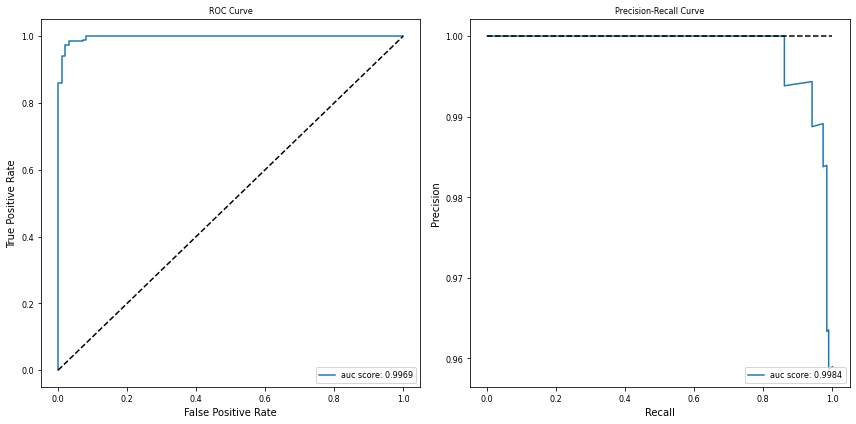

In [98]:
h_line = len(y_test[y_test==1]) / len(y_test) # no skill line in precision/recall curve

_ = plt.subplots(figsize=(12,6))
f1 = plt.subplot(1,2,1)
_ = plt.plot(fpr, tpr)
_ = plt.plot([0,1],[0,1], 'k--')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.legend([f'auc score: {round(roc_auc, 4)}'], loc='lower right')

f2 = plt.subplot(1,2,2)
_ = plt.plot(recall, precision)
_ = plt.plot([0, 1], [h_line, h_line], linestyle='--', color='k')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision-Recall Curve')
_ = plt.legend([f'auc score: {round(pr_auc, 4)}'], loc='lower right')
plt.savefig('ROC_PR.png') 
plt.tight_layout()

### Decision Threshold <a class="anchor" id="fine"></a>

In [79]:
pred_df = pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'threshold':thresholds})

In [80]:
pred_df.head()

,precision,recall,threshold
0,0.958974,1.000000,0.201174
1,0.958763,0.994652,0.219432
2,0.958549,0.989305,0.236430
3,0.963542,0.989305,0.237435
4,0.963351,0.983957,0.256265


In [81]:
beta = 2.0

In [83]:
pred_df = pred_df.assign(fb_2 = lambda x : ((1 + beta**2) * (x.precision * x.recall) / (beta**2 * x.precision + x.recall)))

In [85]:
beta = 3.0
pred_df = pred_df.assign(fb_3 = lambda x : ((1 + beta**2) * (x.precision * x.recall) / (beta**2 * x.precision + x.recall)))

In [86]:
pred_df.head()

,precision,recall,threshold,fb_2,fb_3
0,0.958974,1.000000,0.201174,0.991516,0.995740
1,0.958763,0.994652,0.219432,0.987261,0.990943
2,0.958549,0.989305,0.236430,0.982997,0.986141
3,0.963542,0.989305,0.237435,0.984043,0.986667
4,0.963351,0.983957,0.256265,0.979766,0.981857


In [87]:
pred_df[pred_df.recall == 1].sort_values(by='precision', ascending=False).head(1)

,precision,recall,threshold,fb_2,fb_3
0,0.958974,1.0,0.201174,0.991516,0.99574


In [92]:
pred_df.sort_values('fb_2', ascending=False).head(10)

,precision,recall,threshold,fb_2,fb_3
0,0.958974,1.000000,0.201174,0.991516,0.995740
1,0.958763,0.994652,0.219432,0.987261,0.990943
3,0.963542,0.989305,0.237435,0.984043,0.986667
8,0.983957,0.983957,0.368590,0.983957,0.983957
2,0.958549,0.989305,0.236430,0.982997,0.986141
7,0.978723,0.983957,0.346404,0.982906,0.983431
6,0.973545,0.983957,0.338821,0.981857,0.982906
5,0.968421,0.983957,0.282604,0.980810,0.982381
4,0.963351,0.983957,0.256265,0.979766,0.981857
9,0.983871,0.978610,0.411361,0.979657,0.979133


In [91]:
pred_df.sort_values('fb_3', ascending=False).head(10)


,precision,recall,threshold,fb_2,fb_3
0,0.958974,1.000000,0.201174,0.991516,0.995740
1,0.958763,0.994652,0.219432,0.987261,0.990943
3,0.963542,0.989305,0.237435,0.984043,0.986667
2,0.958549,0.989305,0.236430,0.982997,0.986141
8,0.983957,0.983957,0.368590,0.983957,0.983957
7,0.978723,0.983957,0.346404,0.982906,0.983431
6,0.973545,0.983957,0.338821,0.981857,0.982906
5,0.968421,0.983957,0.282604,0.980810,0.982381
4,0.963351,0.983957,0.256265,0.979766,0.981857
9,0.983871,0.978610,0.411361,0.979657,0.979133


In [93]:
pred_df[pred_df.precision == 1].sort_values(by='recall', ascending=False).head(1)

,precision,recall,threshold,fb_2,fb_3
34,1.0,0.860963,0.864173,0.885589,0.873102


In [101]:
pred_df.to_csv("pre_df.csv")

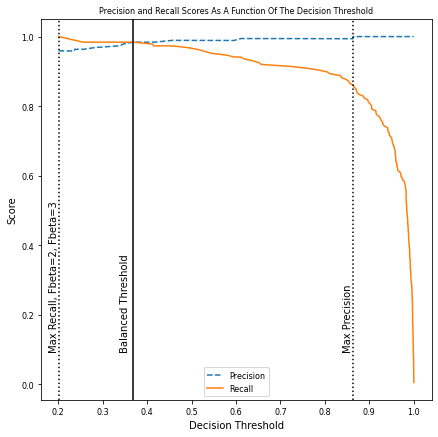

In [103]:
_ = plt.figure(figsize=(7, 7))
_ = plt.title('Precision and Recall Scores As A Function Of The Decision Threshold')
_ = plt.plot(thresholds, precision[:-1], '--', label='Precision')
_ = plt.plot(thresholds, recall[:-1], '-', label='Recall')
_ = plt.axvline(x=0.368590, c='black')
_ = plt.annotate('Balanced Threshold', xy=(0.34,0.1), rotation=90)
_ = plt.axvline(x=0.864173, c='k', ls=':')
_ = plt.annotate('Max Precision', xy=(0.840,0.1), rotation=90)
_ = plt.axvline(x=0.201174, c='k', ls=':')
_ = plt.annotate('Max Recall, Fbeta=2, Fbeta=3', xy=(0.180,0.1), rotation=90)
_ = plt.ylabel('Score')
_ = plt.xlabel('Decision Threshold')
_ = plt.savefig('Decision.png') 
_ = plt.legend(loc='best')

### Classification Report and Confusion Matrix <a class="anchor" id="class"></a>

In [117]:
# Adjust the decision thresholds  
max_pred = np.where(preds >= 0.201174, 1, 0)
bal_pred = np.where(preds >= 0.368590, 1, 0)

In [111]:
target_names = ['malignant', 'benign']

In [119]:
print('Classification Report - Max Recall')
print(classification_report(y_test, max_pred, target_names=target_names))

Classification Report - Max Recall
              precision    recall  f1-score   support

   malignant       1.00      0.92      0.96        98
      benign       0.96      1.00      0.98       187

    accuracy                           0.97       285
   macro avg       0.98      0.96      0.97       285
weighted avg       0.97      0.97      0.97       285



In [123]:
confusion_matrix(y_test, max_pred)

array([[ 90,   8],
       [  0, 187]])

In [120]:
print('Classification Report - Balanced Recall/Precision')
print(classification_report(y_test, bal_pred, target_names=target_names))

Classification Report - Balanced Recall/Precision
              precision    recall  f1-score   support

   malignant       0.96      0.97      0.96        98
      benign       0.98      0.98      0.98       187

    accuracy                           0.98       285
   macro avg       0.97      0.97      0.97       285
weighted avg       0.98      0.98      0.98       285

